# Fibre Neural Network

In [65]:
# Imports
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import matplotlib.ticker as ticker
import random
import os
from functools import singledispatch
from typing import Union

import torch
import torch.nn as nn
from torch.nn import Parameter

# Importing Data - From USB
if os.path.exists("F:/venv code/Y3 Work/Fibres/MATLAB Files"):
    PIM_data = sc.io.loadmat("F:/venv code/Y3 Work/Fibres/MATLAB Files/Modes.mat")
    modes = PIM_data["F2"].transpose(2,0,1) # Modes
    PIMs_torch = torch.tensor(modes, dtype=torch.cfloat)

    beta_data = sc.io.loadmat("F:/venv code/Y3 Work/Fibres/MATLAB Files/Beta.mat")
    beta = beta_data["Beta"] # Phase velocities for each mode
    beta_torch = torch.tensor(beta, dtype=torch.cfloat)

    print("Files imported from USB.")

# Importing Data - From Kaggle
elif os.path.exists("/kaggle/input/fibre-info"):
    PIM_data = sc.io.loadmat("/kaggle/input/fibre-info/Modes.mat")
    modes = PIM_data["F2"].transpose(2,0,1) # Modes
    PIMs_torch = torch.tensor(modes, dtype=torch.cfloat)

    beta_data = sc.io.loadmat("/kaggle/input/fibre-info/Beta.mat")
    beta = beta_data["Beta"] # Phase velocities for each mode
    beta_torch = torch.tensor(beta, dtype=torch.cfloat)

    print("Files imported from Kaggle database.")

else:
    print("No files found.")

# Check if GPU is registered and being used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

if torch.cuda.is_available():
    devNumber = torch.cuda.current_device()
    print(f"The current device number is {devNumber}")

    dev_name = torch.cuda.get_device_name(devNumber)
    print(f"GPU is {dev_name}")
else:
    print(f"No GPU available.")

Files imported from USB.
Using Device: cuda
The current device number is 0
GPU is NVIDIA GeForce RTX 2060


In [93]:
# Functions

# Make a vectorising function
def vectorise(field):
    x = field.shape[0]
    y = field.shape[1]
    return field.reshape(x*y,1)

# Make an unvectorising function
def unvectorise(field, dim):
    return field.reshape(dim,dim)

def Complex2HSV(z, rmin, rmax, hue_start=90):
    # get amplidude of z and limit to [rmin, rmax]
    amp = np.abs(z)
    amp = np.where(amp < rmin, rmin, amp)
    amp = np.where(amp > rmax, rmax, amp)
    ph = np.angle(z, deg=1)# + hue_start
    # HSV are values in range [0,1]
    h = (ph % 360) / 360
    s = 0.85 * np.ones_like(h)
    v = (amp -rmin) / (rmax - rmin)
    return hsv_to_rgb(np.dstack((h,s,v)))

def beta_matrix(length=0):
    """New function to make the diagonal square matrix for PIM propagation in an MMF. Takes inputs from the CPU and will return a tensor on the GPU."""
    beta_data = beta_torch # Needs imported data
    betas = []
    for i in range(len(beta_data)):
        beta = beta_data[i].item().real
        angle = length * beta
        z = np.exp(1j * angle)
        betas.append(z)
    
    # Convert the list to an np.array()
    betas = np.asarray(betas, dtype=np.complex64)
    # Convert the np.array to a torch.tensor()
    betas = torch.as_tensor(betas, device=device)

    # Make the tensor a square diagonal
    betas_diag = torch.diag(betas)

    return betas_diag

def pim_matrix():
    """Creates the real space to pim space conversion matrix. Generated using external data for each PIM's shape."""
    pim = torch.column_stack((PIMs_torch[0].flatten(),PIMs_torch[1].flatten()))
    no_pims = PIMs_torch.size()[0]
    for i in np.arange(2, no_pims, 1):
        pim = torch.column_stack((pim, PIMs_torch[i].flatten()))
    
    # Put onto GPU
    pim = pim.to(device)

    return pim

def real_matrix():
    """Creates the pim space to real space conversion matrix. Generated using external data for each PIM's shape, from the pim_matrix() function."""
    real = torch.transpose(torch.conj(pim_matrix()), dim0=0, dim1=1)

    # Put onto GPU
    real = real.to(device)

    return real

def TM(length=0):
    """Generates the full transmission matrix for a field travelling through a perfectly straight, ideal MMF."""
    real_to_pim = pim_matrix()
    pim_to_real = real_matrix()
    beta = beta_mat(length)
    return real_to_pim @ beta @ pim_to_real

# Make a propagate function to help save time (and less complexity) in the future
def propagate(input_field, length):
    """Takes an input field and the transmission matrix of a multimode optical fibre and finds the output after propagating for a given distance."""
    output_field_vector = TM(length) @ vectorise(input_field).to(device)
    output_field = unvectorise(output_field_vector,31)
    return output_field
    
def loss_fn(output, target):
    return (output - target).abs().square().sum()

def loss_func(outputs, targets):
    """Loss function for multiple sets of training data."""
    loss = 0
    for i in range(len(outputs)):
        loss += (outputs[i] - targets[i]).abs().square().sum()
    loss /= len(outputs)
    return loss

def complex_loss(output, target):
    """Computes the MSE loss for the real and imaginary parts of the fields separately, then adds them to give the final loss."""
    r_loss = 0
    c_loss = 0
    for i in range(len(output)):
        r_loss += (torch.abs(output[i]) - torch.abs(target[i])).abs().square().sum()
        c_loss += (torch.angle(output[i]) - torch.angle(target[i])).abs().square().sum()
    
    r_loss /= len(output)
    c_loss /= len(output)

    loss = c_loss #+ c_loss
    return loss

In [3]:
class Field(torch.Tensor):
    """Class designed around a 2D electric field represented by a torch tensor."""
    def __init__(self, tensor):
        self = tensor

    def normalise(self):
        return self / torch.linalg.matrix_norm(self)

    def visualise(self, title=""):
        """Displays a visual plot of the field, using hsv colour mapping to demonstrate the fields phase (Hue) and amplitude (Value)."""
        # Set up plots
        fig, axs = plt.subplots(1,2, figsize=(10,5))

        # Plot the given field
        axs[0].imshow(Complex2HSV(self, 0, 0.065))

        # Colour bar
        V, H = np.mgrid[0:1:100j, 0:1:300j]
        S = np.ones_like(V)
        HSV = np.dstack((H,S,V))
        RGB = hsv_to_rgb(HSV)

        axs[1].imshow(RGB, origin="lower", extent=[0, 2*np.pi, 0, 1], aspect=15)

        axs[1].set_xticks([0, np.pi, 2*np.pi], ['0', '$\pi$', '$2\pi$'])
        axs[1].set_yticks([0, 1], ['0', '1'])

        axs[1].set_ylabel("Normalised Amplitude")
        axs[1].set_xlabel("Phase (rad.)")

        fig.show()

In [4]:
# Model Class
class LengthModel(nn.Module):

    def __init__(self, length=0.21):
        super(LengthModel, self).__init__()

        # Parameters
        self.length = nn.Parameter(data=torch.tensor([length], dtype=torch.float32, requires_grad=True))
    
    def forward(self, input_field):
        """Forward pass of the model."""
        output_field = propagate(input_field, self.length)
        return output_field

## Main Code

In [102]:
# Important variables
wl = 0.633e-6 #[m] outside the fibre
freq = 299792458 / wl #[Hz] stays same in whatever medium

# Port everything that is needed to the GPU
PIMs_torch = PIMs_torch.to(device)
beta_torch = beta_torch.to(device)

wl_torch = beta_torch / freq #[m] Wavelength of each PIM that can travel through the MMF

In [30]:
beta_torch[1]

tensor([14434328.+0.j], device='cuda:0')

In [31]:
beta_matrix(2.534)

tensor([[-0.5926-0.8055j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.6128+0.7902j,  0.0000+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.5848-0.8112j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        ...,
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
          0.5848-0.8112j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
          0.0000+0.0000j,  0.6128+0.7902j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j, -0.5926-0.8055j]], device='cuda:0')

In [27]:
with open("check_file.txt", "w") as file:
    file.write(f"{beta_matrix(1).data}")

C:\Users\elija\AppData\Local\Temp\ipykernel_18584\1712474207.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\elija\AppData\Local\Temp\ipykernel_18584\1712474207.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


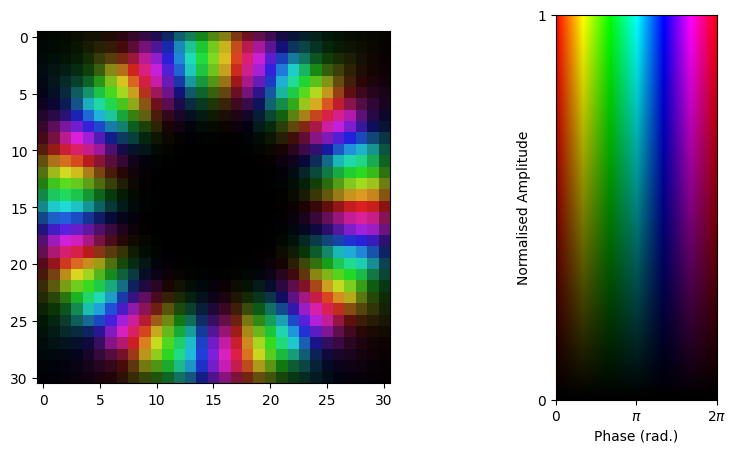

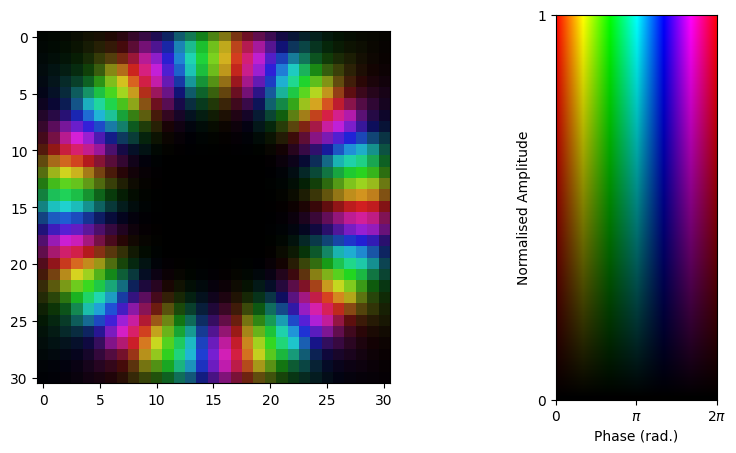

In [94]:
# Make the input and target data using one mode
field_in = PIMs_torch[0]
Field(field_in.cpu()).visualise()

#prop_dist = 0.02
prop_dist = (0.633e-6 / 1.457)
target_field = propagate(field_in, prop_dist)
Field(target_field.cpu()).visualise()

In [95]:
# Run the model with correct parameters to see if it agrees with the target data
model = LengthModel(prop_dist).to(device)
t1 = model(field_in)
# Compute loss
loss = loss_fn(t1, target_field)
loss.item()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [8]:
target_field

tensor([[-9.4181e-04+9.6932e-04j, -8.2449e-04+1.6636e-03j,
         -3.2711e-04+2.5233e-03j,  7.7066e-04+3.3841e-03j,
          2.6534e-03+3.8813e-03j,  5.3061e-03+3.4111e-03j,
          8.2670e-03+1.2203e-03j,  1.0395e-02-3.2590e-03j,
          9.8988e-03-9.7918e-03j,  4.9546e-03-1.6657e-02j,
         -4.9631e-03-2.0509e-02j, -1.7597e-02-1.7527e-02j,
         -2.7624e-02-5.9579e-03j, -2.8853e-02+1.1395e-02j,
         -1.8352e-02+2.7208e-02j,  4.8626e-04+3.3440e-02j,
          1.9137e-02+2.6665e-02j,  2.9176e-02+1.0554e-02j,
          2.7445e-02-6.7564e-03j,  1.7086e-02-1.8032e-02j,
          4.3702e-03-2.0647e-02j, -5.4331e-03-1.6510e-02j,
         -1.0178e-02-9.5039e-03j, -1.0486e-02-2.9589e-03j,
         -8.2290e-03+1.4577e-03j, -5.2061e-03+3.5625e-03j,
         -2.5407e-03+3.9562e-03j, -6.7300e-04+3.4049e-03j,
          3.9958e-04+2.5128e-03j,  8.7202e-04+1.6392e-03j,
          9.6932e-04+9.4181e-04j],
        [-1.6392e-03+8.7202e-04j, -1.8146e-03+1.8676e-03j,
         -1.5475e-03+

In [9]:
t1

tensor([[-9.4181e-04+9.6932e-04j, -8.2449e-04+1.6636e-03j,
         -3.2711e-04+2.5233e-03j,  7.7066e-04+3.3841e-03j,
          2.6534e-03+3.8813e-03j,  5.3061e-03+3.4111e-03j,
          8.2670e-03+1.2203e-03j,  1.0395e-02-3.2590e-03j,
          9.8988e-03-9.7918e-03j,  4.9546e-03-1.6657e-02j,
         -4.9631e-03-2.0509e-02j, -1.7597e-02-1.7527e-02j,
         -2.7624e-02-5.9579e-03j, -2.8853e-02+1.1395e-02j,
         -1.8352e-02+2.7208e-02j,  4.8626e-04+3.3440e-02j,
          1.9137e-02+2.6665e-02j,  2.9176e-02+1.0554e-02j,
          2.7445e-02-6.7564e-03j,  1.7086e-02-1.8032e-02j,
          4.3702e-03-2.0647e-02j, -5.4331e-03-1.6510e-02j,
         -1.0178e-02-9.5039e-03j, -1.0486e-02-2.9589e-03j,
         -8.2290e-03+1.4577e-03j, -5.2061e-03+3.5625e-03j,
         -2.5407e-03+3.9562e-03j, -6.7300e-04+3.4049e-03j,
          3.9958e-04+2.5128e-03j,  8.7202e-04+1.6392e-03j,
          9.6932e-04+9.4181e-04j],
        [-1.6392e-03+8.7202e-04j, -1.8146e-03+1.8676e-03j,
         -1.5475e-03+

0
100
200
300
400
500
600
700
800
900


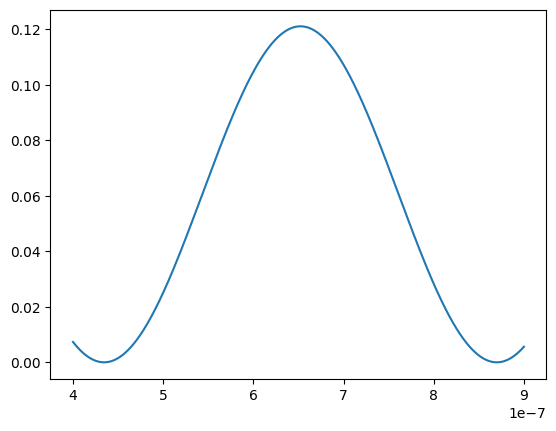

In [10]:
# Plot the loss function for the target data and a spread of fibre distances, showing the disagreement.
loss = []
xs = torch.from_numpy(np.linspace(4e-7,9e-7,1000))

for i in range(xs.size()[0]):
    model = LengthModel(length=xs[i]).to(device)
    field_out = model(field_in)
    loss.append(loss_func(field_out, target_field).cpu().detach().numpy())

    if i % 100 == 0:
        print(i)

plt.plot(xs,loss)

In [11]:
# Try to use n PIMs to make the loss function smoother and wider
n = 2
#prop_dist = 0.02
prop_dist = (0.633e-6 / 1.457)

fields_in = PIMs_torch[0:n]
#for i in range(n):
#    Field(fields_in[i].cpu()).visualise()

# Target fields 
target_fields = []
for i in range(n):
    field = propagate(fields_in[i], prop_dist)
    target_fields.append(field)

#for i in range(n):
#    Field(target_fields[i].cpu()).visualise()

In [12]:
# Run the model with correct parameters to see if it agrees with the target data
model = LengthModel(prop_dist).to(device)
fields_out = []
for i in range(n):
    field = model(fields_in[i])
    fields_out.append(field)

# Compute loss
loss = loss_func(fields_out, target_fields)
loss.item()

0.0

0
100
200
300
400
500
600
700
800
900


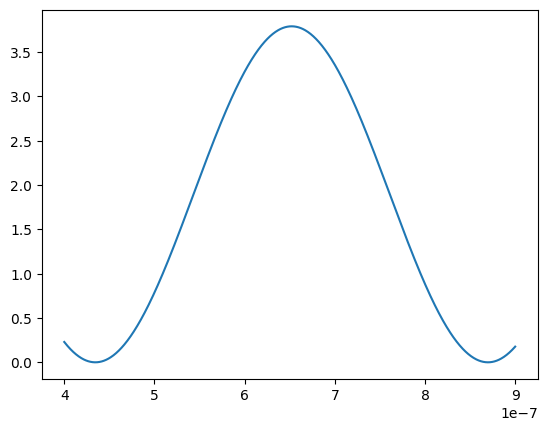

In [13]:
# Plot the loss function for the target data and a spread of fibre distances, showing the disagreement.
loss = []
xs = torch.from_numpy(np.linspace(4e-7,9e-7,1000))

for i in range(xs.size()[0]):
    model = LengthModel(length=xs[i]).to(device)
    fields_out = []

    for j in range(n):
        field = model(fields_in[j])
        fields_out.append(field)

    loss.append(loss_func(fields_out, target_fields).cpu().detach().numpy())

    if i % 100 == 0:
        print(i)

plt.plot(xs,loss)

Epoch 0, Loss: 7110.51708984375, Length: 0.01990099996328354
Epoch 100, Loss: 4270.5, Length: 0.01994476094841957
Epoch 200, Loss: 8543.9453125, Length: 0.019985828548669815
Epoch 300, Loss: 2719.65087890625, Length: 0.020025629550218582
Epoch 400, Loss: 4381.4130859375, Length: 0.020096683874726295

Final Loss: 1329.384033203125
Final length: 0.020139679312705994


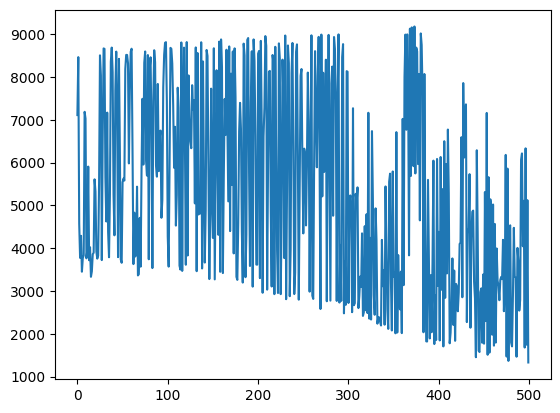

In [14]:
# See if the model can be used to train an optimiser
model = LengthModel(0.0199).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-6)

epochs = 500
epoch_list = []
loss_list = []

for epoch in range(epochs):
    optimiser.zero_grad()

    fields_out = []
    for i in range(n):
        field = model(fields_in[i])
        fields_out.append(field)

    loss = complex_loss(fields_out, target_fields)
    loss.backward()
    optimiser.step()

    epoch_list.append(epoch)
    loss_list.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, Length: {model.length.item()}")

print(f"\nFinal Loss: {loss.item()}")
print(f"Final length: {model.length.item()}")

plt.plot(epoch_list, loss_list)

0
100
200
300
400


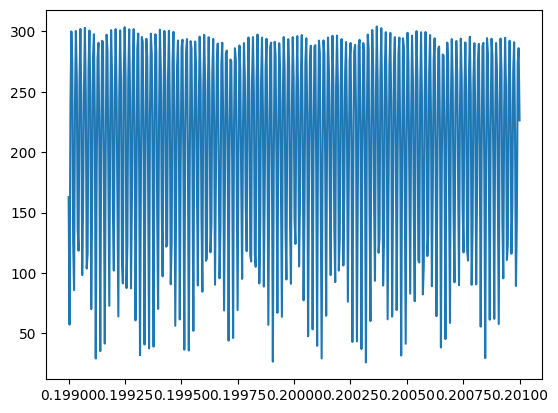

In [15]:
# Plot the loss function for the target data and a spread of fibre distances, showing the disagreement.
loss = []
xs = torch.from_numpy(np.linspace(0.199,0.201,500))

for i in range(xs.size()[0]):
    model = LengthModel(length=xs[i]).to(device)
    field_out = model(field_in)
    loss.append(complex_loss(field_out, target_field).cpu().detach().numpy())

    if i % 100 == 0:
        print(i)

plt.plot(xs,loss)

In [16]:
beta_torch[1].item() / freq

NameError: name 'freq' is not defined

In [17]:
freq = np.double(600e12)
wl0 = beta_torch[0] / freq
wl1 = beta_torch[1] / freq

print(wl0)

ratio = wl0 / wl1
print(ratio)

dist0 = 10000 * wl0
print(f"d1 = {dist0.item()}")
dist1 = 9996 * wl1
print(f"d2 = {dist1.item()}")

if dist0 == dist1:
    print("Same")
else:
    print("Not same")

test = dist0 / wl1
test

tensor([2.4048e-08+0.j], device='cuda:0')
tensor([0.9996+0.j], device='cuda:0')
d1 = (0.000240483830566518+0j)
d2 = (0.00024047589977271855+0j)
Not same


tensor([9996.3301+0.j], device='cuda:0')

C:\Users\elija\AppData\Local\Temp\ipykernel_18584\1712474207.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\elija\AppData\Local\Temp\ipykernel_18584\1712474207.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\elija\AppData\Local\Temp\ipykernel_18584\1712474207.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\elija\AppData\Local\Temp\ipykernel_18584\1712474207.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


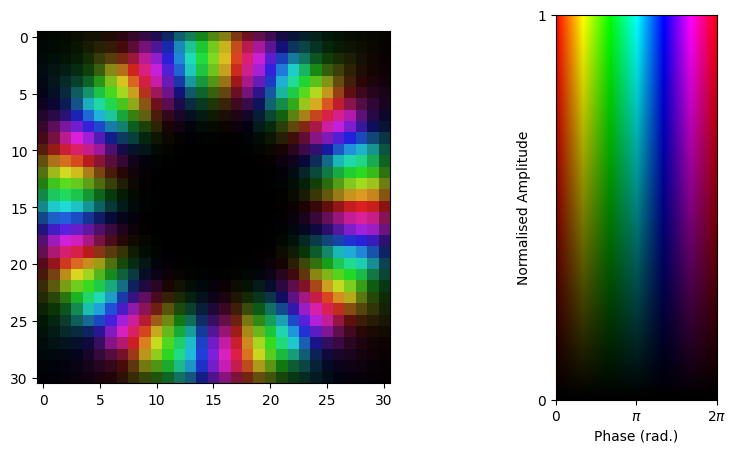

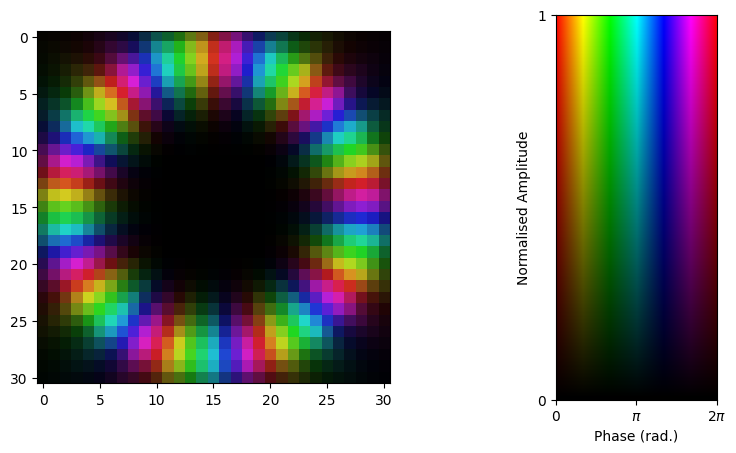

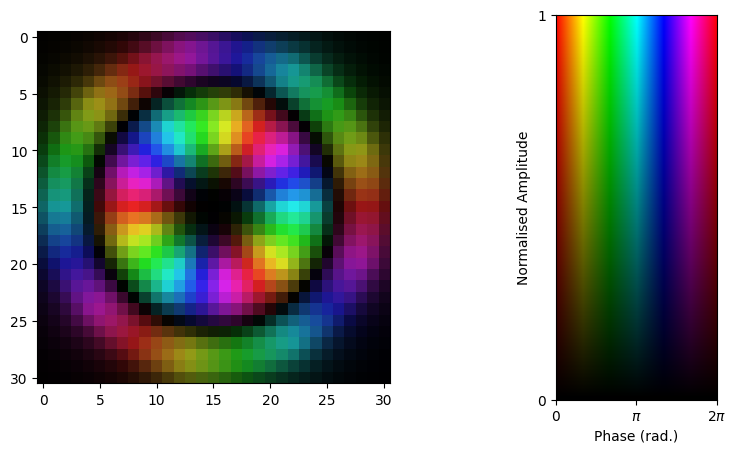

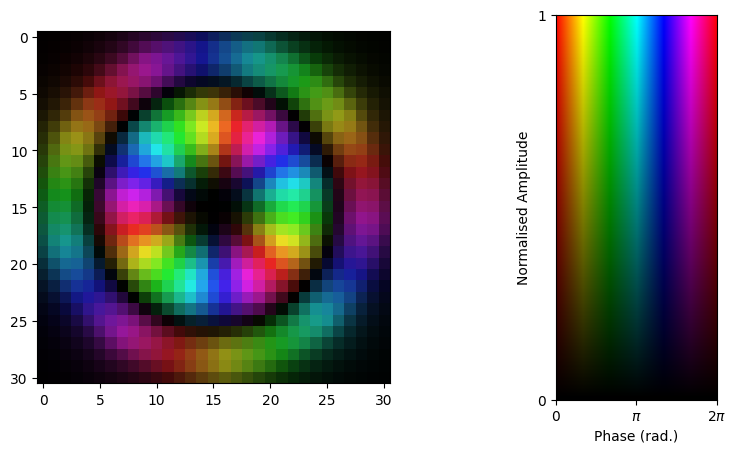

In [18]:
field_in_0 = PIMs_torch[0]
field_in_1 = PIMs_torch[10]

prop_dist = (0.633e-6 / 1.457) * 100
target_field_0 = propagate(field_in_0, prop_dist)
target_field_1 = propagate(field_in_1, prop_dist)

Field(field_in_0.cpu()).visualise()
Field(target_field_0.cpu()).visualise()

Field(field_in_1.cpu()).visualise()
Field(target_field_1.cpu()).visualise()

In [36]:
length = 2.534
torch.exp(1j * length * beta_torch)

tensor([[-0.5926-0.8055j],
        [ 0.6128+0.7902j],
        [ 0.5848-0.8112j],
        [-0.7941+0.6077j],
        [-0.9386-0.3451j],
        [-0.8724+0.4888j],
        [-0.7594+0.6506j],
        [ 0.3806+0.9247j],
        [-0.2402-0.9707j],
        [ 0.0181+0.9998j],
        [ 0.9278+0.3731j],
        [-0.9985+0.0540j],
        [ 0.1234+0.9924j],
        [ 0.0193+0.9998j],
        [-0.6601-0.7512j],
        [-0.8506-0.5259j],
        [ 0.9983-0.0582j],
        [ 0.4494-0.8933j],
        [-0.4727-0.8812j],
        [-0.8504-0.5262j],
        [ 0.4987-0.8668j],
        [ 0.1952+0.9808j],
        [-0.5626+0.8267j],
        [-0.8506-0.5259j],
        [ 0.9983-0.0582j],
        [ 0.4494-0.8933j],
        [-0.4727-0.8812j],
        [ 0.1234+0.9924j],
        [ 0.0193+0.9998j],
        [-0.6601-0.7512j],
        [ 0.0181+0.9998j],
        [ 0.9278+0.3731j],
        [-0.9985+0.0540j],
        [ 0.3806+0.9247j],
        [-0.2402-0.9707j],
        [-0.8724+0.4888j],
        [-0.7594+0.6506j],
 

In [54]:
length = 2.534
angle = length * beta_torch[0]
z = torch.cos(angle) + 1j*torch.sin(angle)
z

tensor([-0.5926-0.8055j], device='cuda:0')

In [56]:
length = 2.534
angle = length * beta_torch[0]
z = np.cos(angle.cpu()) + 1j*np.sin(angle.cpu())
z

tensor([-0.5926-0.8055j])

In [67]:
length = 2.534
beta = beta_torch[0].item().real
angle = length * beta
z = np.cos(angle) + 1j*np.sin(angle)
z

(0.9829322198984538-0.18396807083159183j)

In [60]:
print(f"Beta_torch is: {beta_torch[0]}")
print(f"Beta is: {beta}")

Beta_torch is: tensor([14429030.+0.j], device='cuda:0')
Beta is: 14429030.0


In [85]:
def beta_mat(length=0):
    """New function to make the diagonal square matrix for PIM propagation in an MMF. Takes inputs from the CPU and will return a tensor on the GPU."""
    beta_data = beta_torch # Needs imported data
    betas = []
    for i in range(len(beta_data)):
        beta = beta_data[i].item().real
        angle = length * beta
        z = np.exp(1j * angle)
        betas.append(z)
    
    # Convert the list to an np.array()
    betas = np.asarray(betas, dtype=np.complex64)
    # Convert the np.array to a torch.tensor()
    betas = torch.as_tensor(betas, device=device)

    # Make the tensor a square diagonal
    betas_diag = torch.diag(betas)

    return betas_diag

def pim_matrix():
    """Creates the real space to pim space conversion matrix. Generated using external data for each PIM's shape."""
    pim = torch.column_stack((PIMs_torch[0].flatten(),PIMs_torch[1].flatten()))
    no_pims = PIMs_torch.size()[0]
    for i in np.arange(2, no_pims, 1):
        pim = torch.column_stack((pim, PIMs_torch[i].flatten()))
    
    # Put onto GPU
    pim = pim.to(device)

    return pim

def real_matrix():
    """Creates the pim space to real space conversion matrix. Generated using external data for each PIM's shape, from the pim_matrix() function."""
    real = torch.transpose(torch.conj(pim_matrix()), dim0=0, dim1=1)

    # Put onto GPU
    real = real.to(device)

    return real

def TM_new(length=0):
    """Generates the full transmission matrix for a field travelling through a perfectly straight, ideal MMF."""
    real_to_pim = pim_matrix()
    pim_to_real = real_matrix()
    beta = beta_mat(length)
    return real_to_pim @ beta @ pim_to_real

# Make a propagate function to help save time (and less complexity) in the future
def propagate_new(input_field, length):
    """Takes an input field and the transmission matrix of a multimode optical fibre and finds the output after propagating for a given distance."""
    output_field_vector = TM(length) @ vectorise(input_field).to(device)
    output_field = unvectorise(output_field_vector,31)
    return output_field


C:\Users\elija\AppData\Local\Temp\ipykernel_18584\1712474207.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\elija\AppData\Local\Temp\ipykernel_18584\1712474207.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


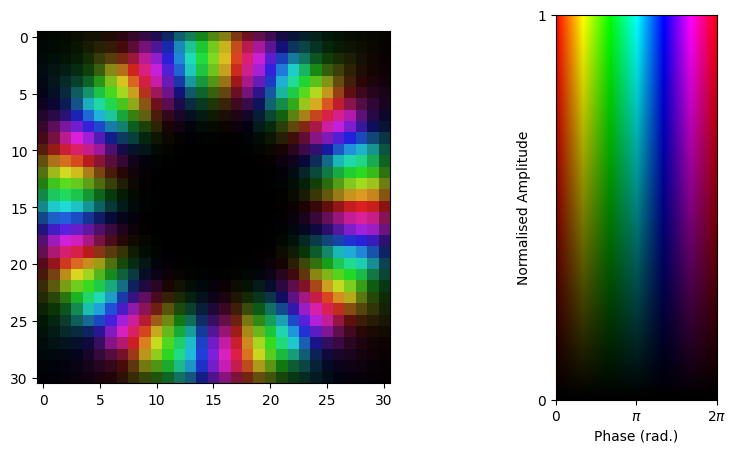

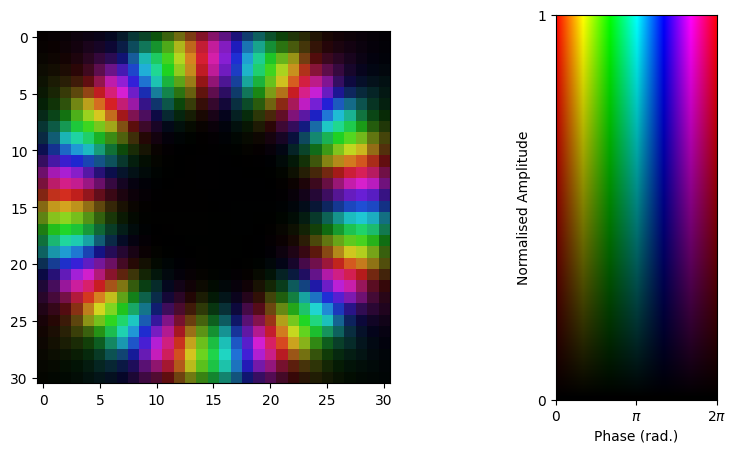

In [104]:
field_in = PIMs_torch[0]
Field(field_in.cpu()).visualise()


field_out = propagate(field_in, 2.5)
Field(field_out.cpu()).visualise()

In [103]:
model = LengthModel(2.5).to(device)
mod_field = model(field_in)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.